# Modersmærkekræft recognition

In [6]:
train_dir = "Data Set Ordered/training data/"
val_dir = "Data Set Ordered/validation data/"
test_dir = "Data Set Ordered/test data/"

## Iteration 1

In [12]:
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
      layer.trainable = False

  # Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])



Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.


In [13]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='models/best_model1.keras',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Train the model with the callback
history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    verbose=1,
    callbacks=[checkpoint_callback]  # Add both callbacks
)

Epoch 1/100


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6235 - loss: 10.7966
Epoch 1: val_loss improved from inf to 4.83319, saving model to models/best_model1.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 91ms/step - accuracy: 0.6237 - loss: 10.7883 - val_accuracy: 0.7358 - val_loss: 4.8332
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7547 - loss: 4.9483
Epoch 2: val_loss improved from 4.83319 to 3.98370, saving model to models/best_model1.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.7548 - loss: 4.9469 - val_accuracy: 0.6995 - val_loss: 3.9837
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8218 - loss: 2.7497
Epoch 3: val_loss did not improve from 3.98370
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.8218 - loss: 2.7506 - val_accuracy: 0.7409 - val_loss: 5.4454
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8429 - loss: 2.2100
Epoch 4: val_loss improved from 3.98370 to 2.95293, saving model to mode

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━

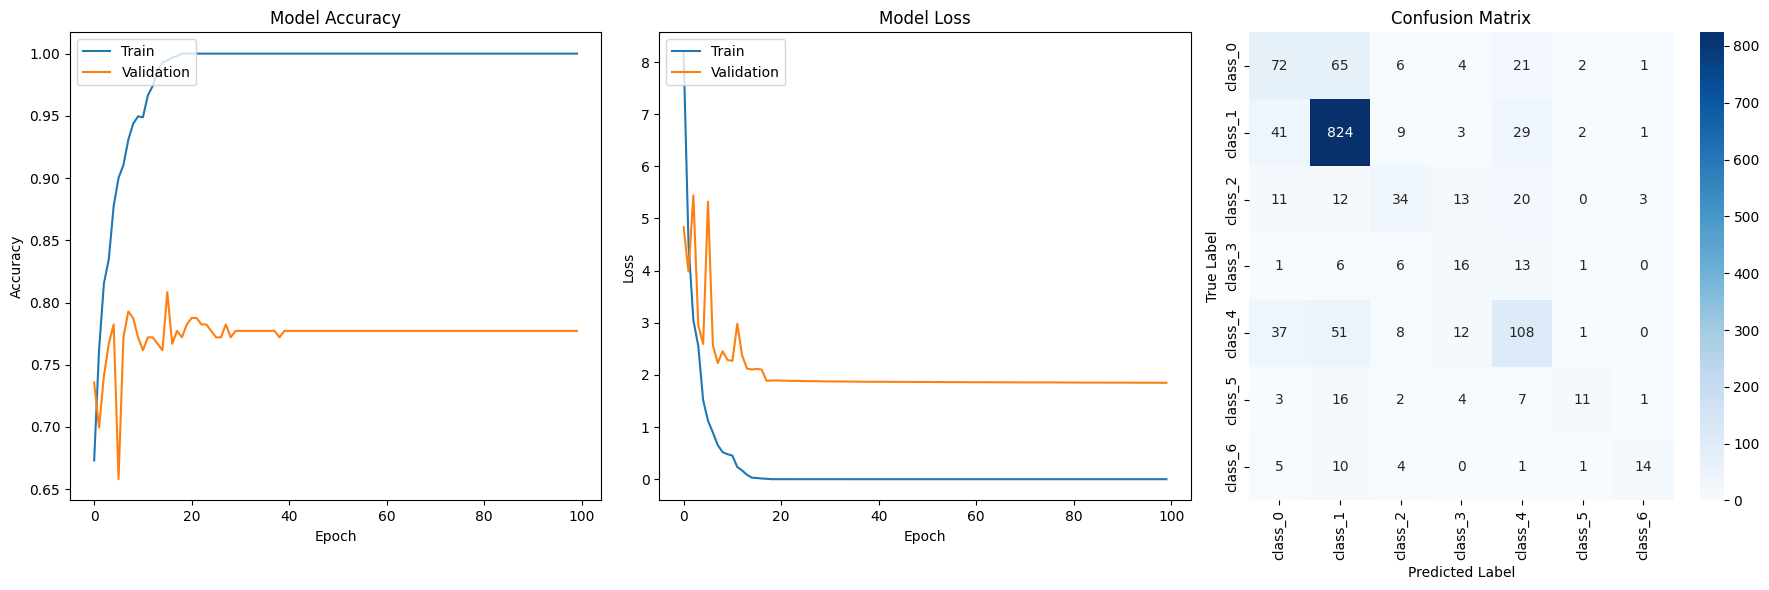

In [16]:
show_all_plots(history2, model, test_generator)

In [17]:
results = model.evaluate(test_generator)

 1/48 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.6875 - loss: 2.5457

/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7042 - loss: 4.7873


### What did we learn????

- Overfitting:
    - No
- Efficiency:
    - Super fint - den er hurtig (30 sec per epoch - 100=51 min)
- Performance:
    - Accuracy -> train=100, val=77.72, test: 70.42
    - loss -> train=fuckinglav, val=1.84854, test=4.7873

Takaways:
- We do not overfit, so we can try with a more complex model?
- We did not expect it to learn to differentiate between the 7 classes as they are very unbalanced.
- We did not expect it to learn this much
- It doesnt learn that well for val/test and there is a large gap between train and the others

What to do next time?
- Experiment with Learning Rate
    - we can observe that model has "plateaued", meaning that the validation loss neither goes up or down, 
    with the use of a Learning Rate Scheduler we could force the model out of the plateau and maybe achieve a lower loss (maybe?).
    - week 6 slide11
- Experiment with Regularization 
    - we can observe that there is a significant difference between the loss in train and val. This can be tackle by implementing regularization techniques.
        - Data augmentation
        - Early Stopping! (always do this)
        - Dropout
        - Add Noise when training

## Iteration 2

This is a script to test what learning rate we should use (and scheduler)

In [2]:
import os

# Set CUDA_LAUNCH_BLOCKING to 1
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Now you can import TensorFlow and run your code
import tensorflow as tf

# Your training code here


In [ ]:

from keras.optimizers import SGD
from tensorflow.keras import optimizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

batch_size = 32
epochs = 50


train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])






# Custom callback to record the learning rate at each epoch
class LearningRateTracker(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Check if learning rate is a callable schedule (like InverseTimeDecay)
        if callable(self.model.optimizer.learning_rate):
            # Get current learning rate by calling the schedule with the current step
            step = self.model.optimizer.iterations
            lr = self.model.optimizer.learning_rate(step).numpy()
        else:
            # Directly access learning rate if it's a fixed value
            lr = self.model.optimizer.learning_rate.numpy()
        
        if not hasattr(self, 'learning_rates'):
            self.learning_rates = []
        self.learning_rates.append(lr)


# To store learning rates per decay strategy
learning_rates_dict = {}



total_number_of_images = train_generator.samples



initial_lr = 0.01
decay_rate = initial_lr * 0.01
# Learning rate decay functions
def linear_decay(epoch, initial_lr=initial_lr, decay_rate=decay_rate):
    return initial_lr - decay_rate * epoch

initial_lr = 0.01
decay_rate = 0.1
def inverse_sqrt_decay(epoch, initial_lr=initial_lr, decay_rate=decay_rate):
    return initial_lr / np.sqrt(1 + decay_rate * epoch)

initial_lr = 0.01
drop = 0.5
epochs_drop = 1/5 * epochs
def step_decay(epoch, initial_lr=initial_lr, drop=drop, epochs_drop=epochs_drop):
    return initial_lr * (drop ** np.floor((1 + epoch) / epochs_drop))


fraction = 0.1
total_number_trainingsteps = (total_number_of_images / batch_size) * epochs

initial_learning_rate = 0.1
decay_steps = total_number_trainingsteps * 0.1
decay_rate = 0.5
inverse_time_decay = optimizers.schedules.InverseTimeDecay(
    initial_learning_rate, decay_steps, decay_rate)


starter_learning_rate = 0.1
end_learning_rate = starter_learning_rate * 0.1 
decay_steps = total_number_trainingsteps * 0.75
power = 0.3

print("decay steps", decay_steps)

polynomial_decay = optimizers.schedules.PolynomialDecay(
    initial_learning_rate=starter_learning_rate,
    decay_steps=decay_steps,
    end_learning_rate=end_learning_rate,
    power=power
)


initial_learning_rate = 0.1
decay_steps = total_number_trainingsteps * 0.1
decay_rate = 0.96
exponential_decay = optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)


sgd_configs = {}
#sgd_configs.update({f'cosine_with_warmup_decay': SGD(learning_rate=cosine_with_warmup_decay)})
sgd_configs.update({f'inverse_time_decay': SGD(learning_rate=inverse_time_decay)})
sgd_configs.update({f'polynomial_decay': SGD(learning_rate=polynomial_decay)})
sgd_configs.update({f'exponential_decay': SGD(learning_rate=exponential_decay)})
sgd_configs.update({f'constant': SGD(learning_rate=0.001)})



config_callbacks = {
    'linear_decay': {
        'callback': LearningRateScheduler(lambda epoch: linear_decay(epoch)),
    },
    'inverse_sqrt_decay': {
        'callback': LearningRateScheduler(lambda epoch: inverse_sqrt_decay(epoch)),
    },
    'step_decay': {
        'callback': LearningRateScheduler(lambda epoch: step_decay(epoch)),
    },
}

results = {}

for key in config_callbacks:

    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output
    x = Flatten()(x)
    preds = Dense(7,activation='softmax')(x)

    # Define the complete model
    model = Model(inputs=base_model.input, outputs=preds)


    # Compile model - make it trainable
    model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
    lr_tracker = LearningRateTracker()
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[config_callbacks[key]['callback'], lr_tracker])

    learning_rates_dict[key] = lr_tracker.learning_rates
    # Evaluate the model on the validation set
    val_loss, val_acc = model.evaluate(validation_generator)
    results[f"{key}"] = history
    print(f'{key} ------>>>>>> Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}\n')


for key in sgd_configs:

    sgd = sgd_configs[key]

    lr_tracker = LearningRateTracker()

    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output
    x = Flatten()(x)
    preds = Dense(7,activation='softmax')(x)

    # Define the complete model
    model = Model(inputs=base_model.input, outputs=preds)


    # Compile model - make it trainable
    model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[lr_tracker]
    )

    learning_rates_dict[key] = lr_tracker.learning_rates
    # Evaluate the model on the validation set
    val_loss, val_acc = model.evaluate(validation_generator)
    results[key] = history
    print(f'{key} ------>>>>>> Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}\n')




# Plotting learning rate decay over time for each configuration
plt.figure(figsize=(12, 8))
for key, lrs in learning_rates_dict.items():
    plt.plot(range(len(lrs)), lrs, label=f'{key} LR decay')

plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay Comparison')
plt.legend()
plt.show()

for key, history in results.items():
    print(f"{key}: val_acc: {history.history['val_accuracy'][-1]}, val_loss: {history.history['val_loss'][-1]}")


Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.
decay steps 11736.328125
Epoch 1/50
313/313 [==============================] - 64s 196ms/step - loss: 8.2374 - accuracy: 0.6707 - val_loss: 3.0076 - val_accuracy: 0.7720 - lr: 0.0100
Epoch 2/50
313/313 [==============================] - 20s 65ms/step - loss: 4.3848 - accuracy: 0.7619 - val_loss: 2.5217 - val_accuracy: 0.7927 - lr: 0.0099
Epoch 3/50
313/313 [==============================] - 20s 65ms/step - loss: 2.7119 - accuracy: 0.8227 - val_loss: 4.8813 - val_accuracy: 0.7150 - lr: 0.0098
Epoch 4/50
313/313 [==============================] - 20s 64ms/step - loss: 2.1482 - accuracy: 0.8469 - val_loss: 3.9077 - val_accuracy: 0.7513 - lr: 0.0097
Epoch 5/50
313/313 [==============================] - 21s 66ms/step - loss: 1.5558 - accuracy: 0.8753 - val_loss: 2.4586 - val_accuracy: 0.8031 - lr: 0.0096
Epoch 6/50
313/313 [==============================] - 21s 66ms/

linear_decay: val_acc: 0.7979274392127991, val_loss: 1.8466776609420776


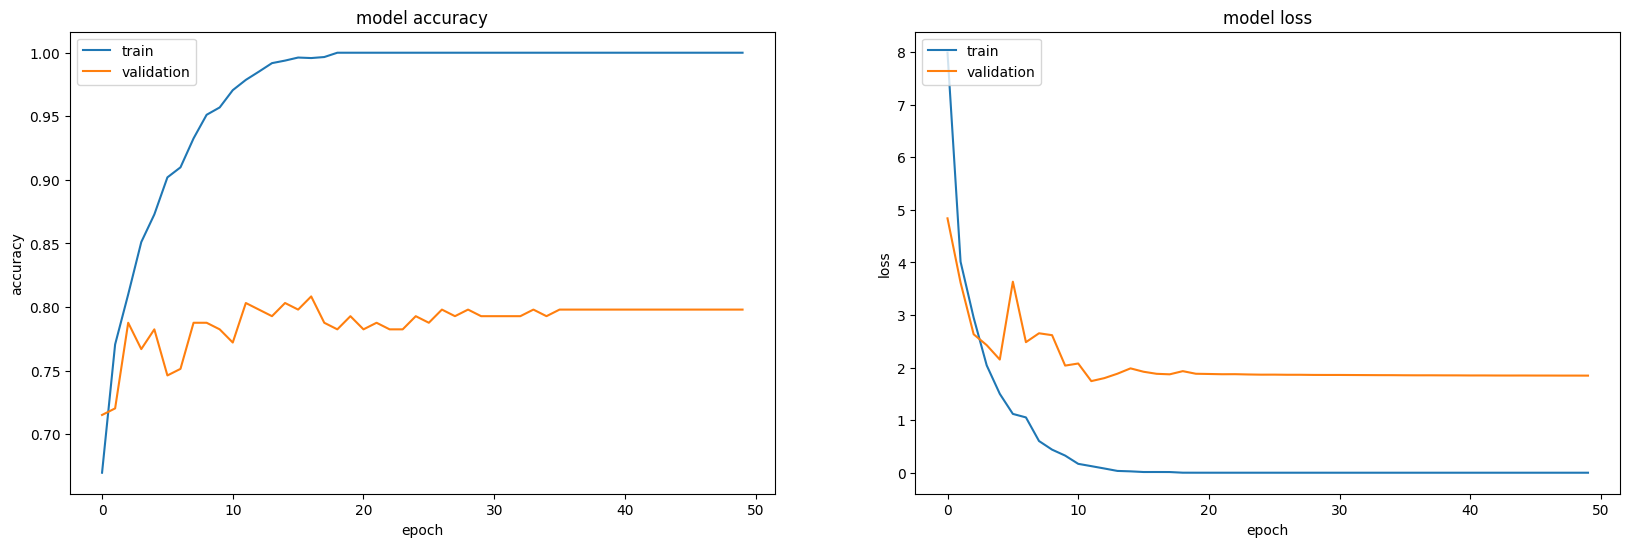

inverse_sqrt_decay: val_acc: 0.7979274392127991, val_loss: 1.557247519493103


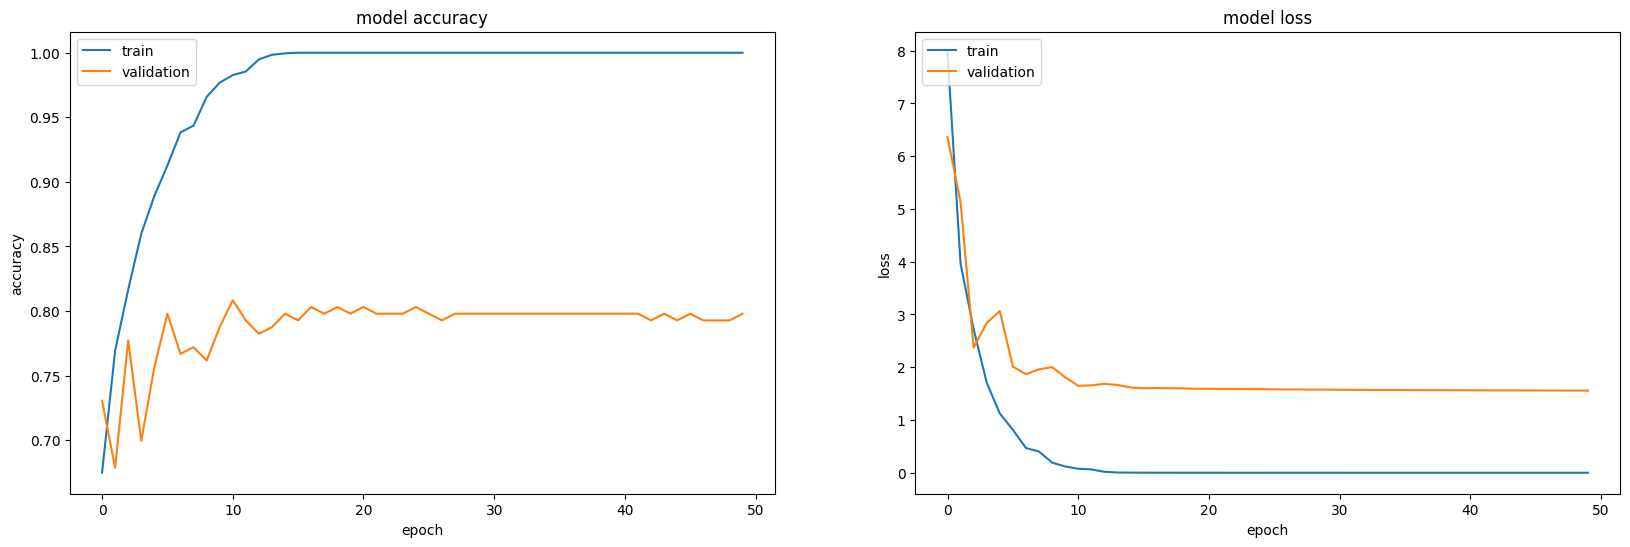

step_decay: val_acc: 0.8082901835441589, val_loss: 1.8573381900787354


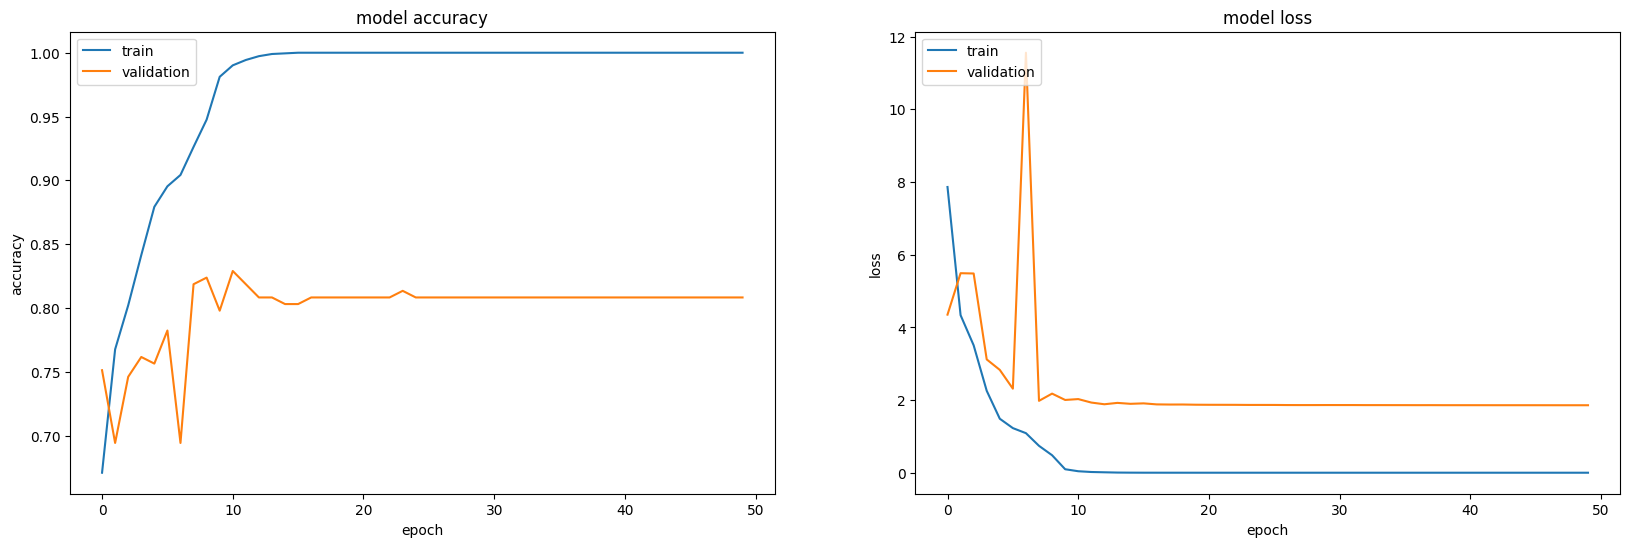

inverse_time_decay: val_acc: 0.7979274392127991, val_loss: 4.162773609161377


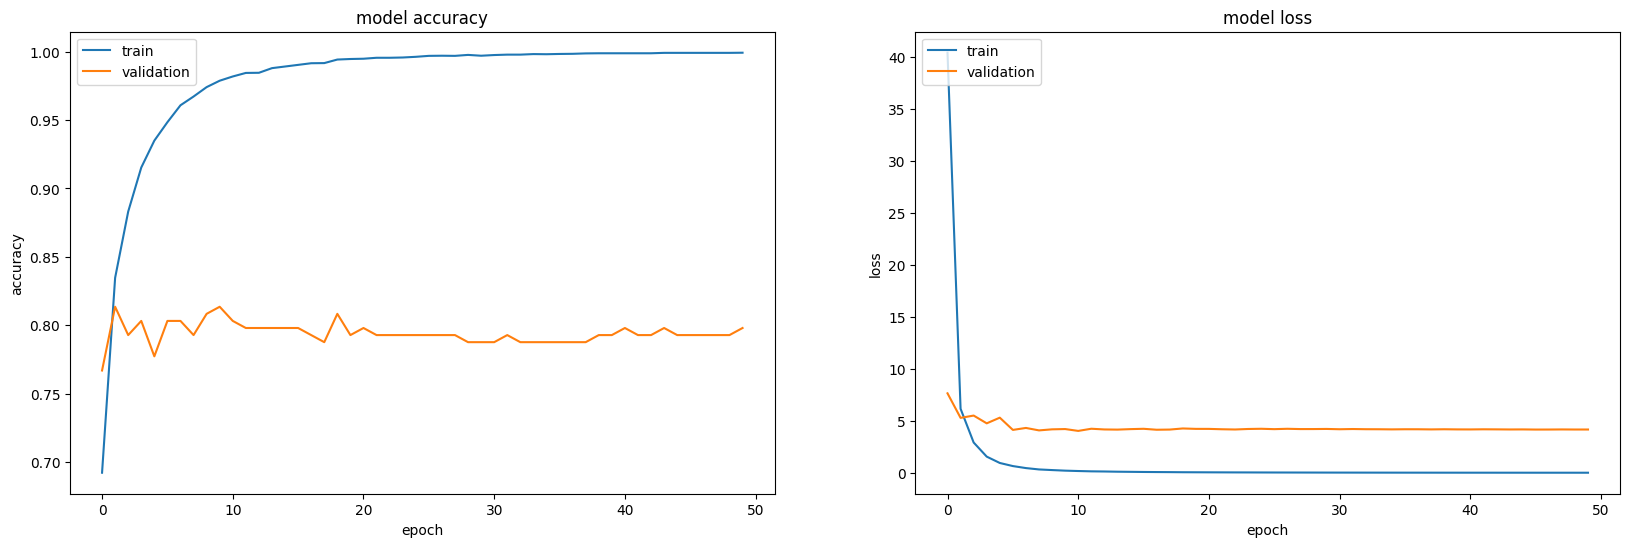

polynomial_decay: val_acc: 0.772020697593689, val_loss: 8.179764747619629


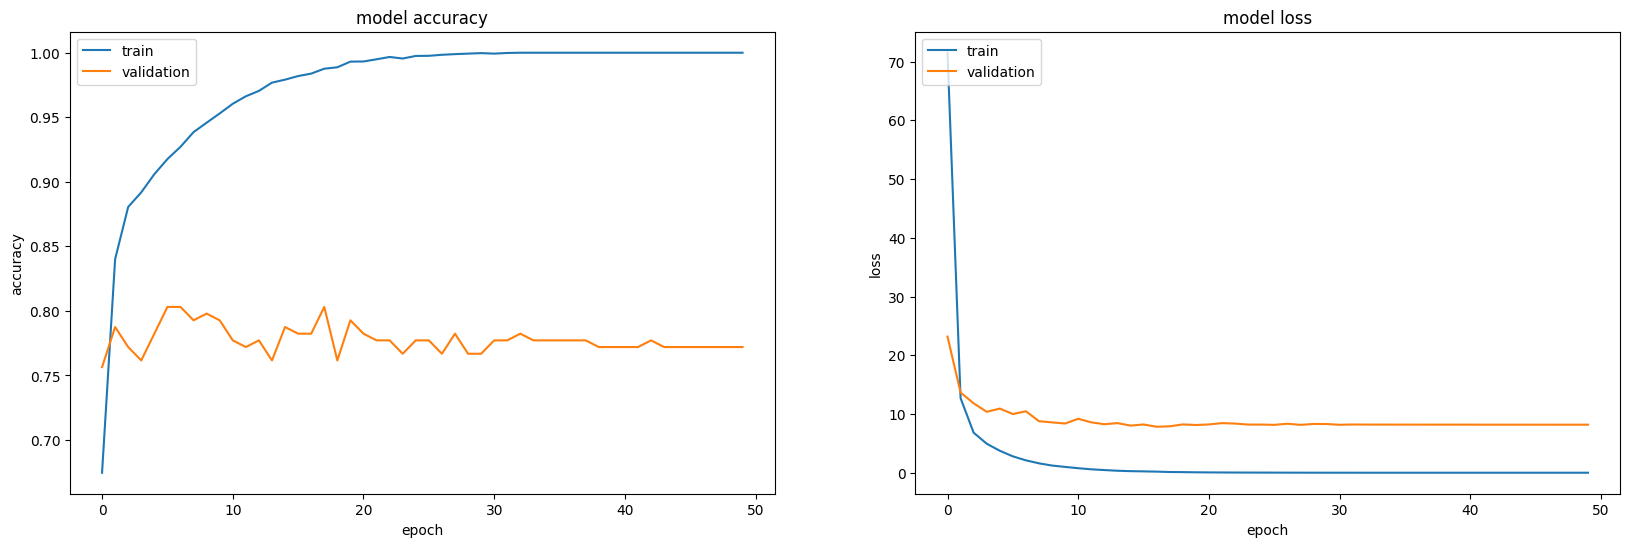

exponential_decay: val_acc: 0.7772020697593689, val_loss: 11.33125114440918


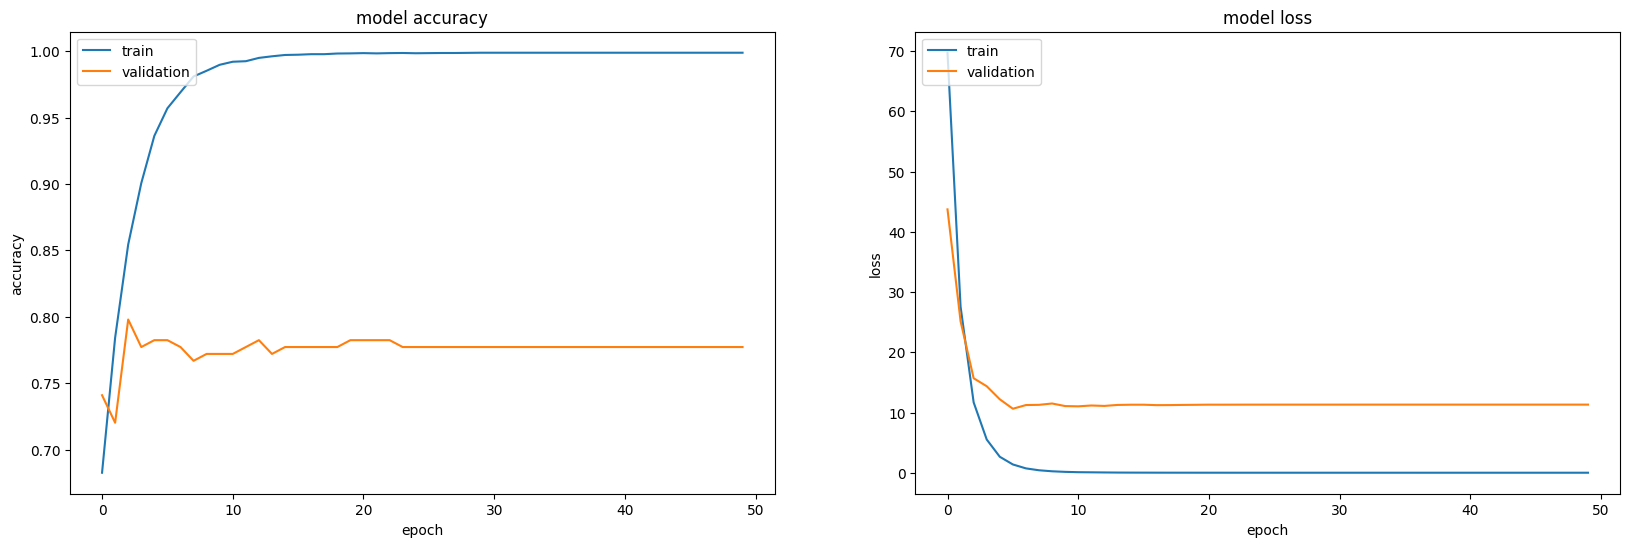

constant: val_acc: 0.787564754486084, val_loss: 0.5415298938751221


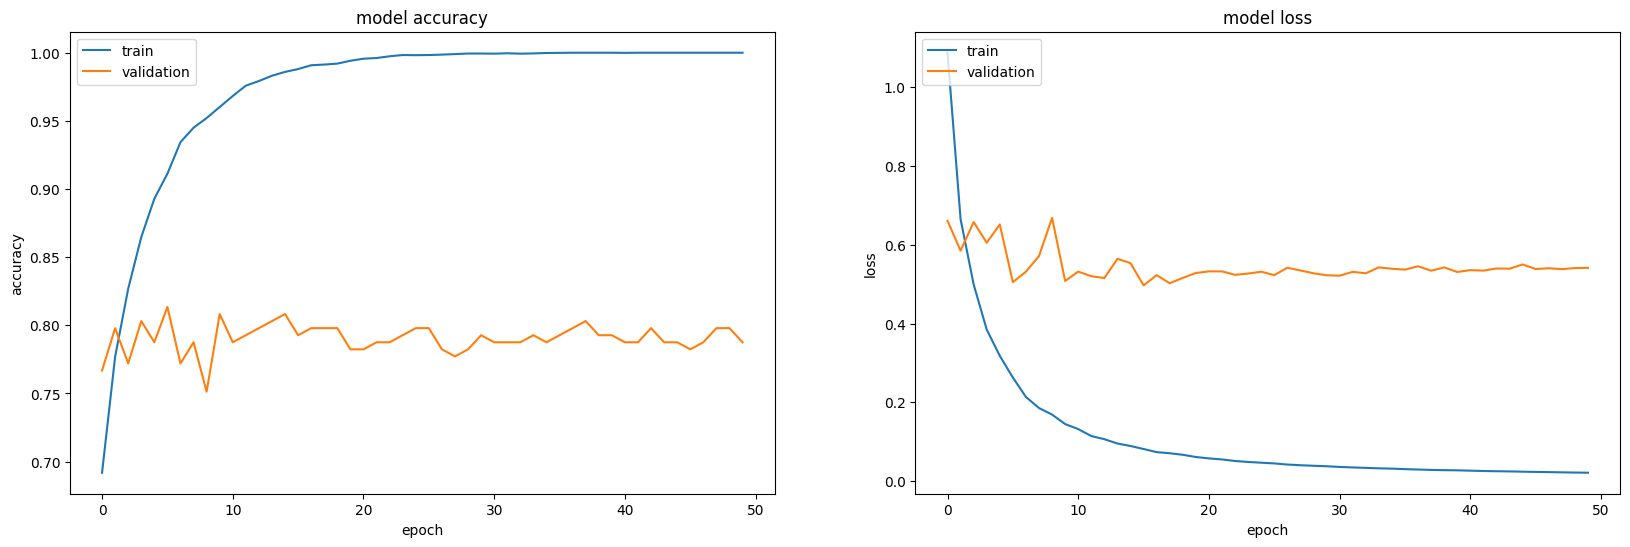

In [8]:
for key, history in results.items():
    print(f"{key}: val_acc: {history.history['val_accuracy'][-1]}, val_loss: {history.history['val_loss'][-1]}")
    show_history(history)

## Iteration 3

In [ ]:
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)


Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.


Epoch 1/10
313/313 [==============================] - 22s 64ms/step - loss: 1.2312 - accuracy: 0.6374 - val_loss: 0.7513 - val_accuracy: 0.7461
Epoch 2/10
313/313 [==============================] - 19s 61ms/step - loss: 1.0972 - accuracy: 0.7161 - val_loss: 1.1691 - val_accuracy: 0.6736
Epoch 3/10
313/313 [==============================] - 19s 61ms/step - loss: 1.3515 - accuracy: 0.7483 - val_loss: 0.8442 - val_accuracy: 0.7720
Epoch 4/10
313/313 [==============================] - 19s 61ms/step - loss: 1.6413 - accuracy: 0.7667 - val_loss: 2.4243 - val_accuracy: 0.7617
Epoch 5/10
313/313 [==============================] - 19s 60ms/step - loss: 1.6117 - accuracy: 0.7932 - val_loss: 1.4892 - val_accuracy: 0.7358
Epoch 6/10
313/313 [==============================] - 19s 62ms/step - loss: 1.6569 - accuracy: 0.8139 - val_loss: 2.3013 - val_accuracy: 0.7098
Epoch 7/10
313/313 [==============================] - 19s 61ms/step - loss: 1.9731 - accuracy: 0.8188 - val_loss: 3.3947 - val_accuracy:

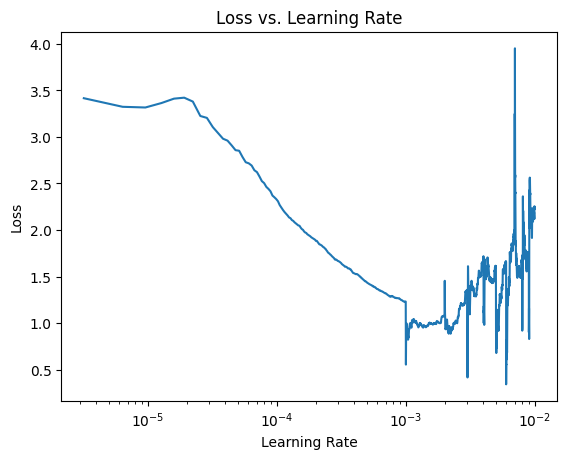

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import Callback
from keras.applications import MobileNetV3Small
# Hyperparameters
min_lr = 1e-10
max_lr = 0.01
epochs = 10
total_number_of_images = train_generator.samples
batch_size = 32
steps_per_epoch = total_number_of_images / batch_size  # Update this based on your training dataset


# Custom callback to increase learning rate linearly after each batch
class LinearLRScheduler(Callback):
    def __init__(self, min_lr, max_lr, steps_per_epoch, total_epochs):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps_per_epoch = steps_per_epoch
        self.total_epochs = total_epochs
        self.batch_count = 0
        self.total_batches = steps_per_epoch * total_epochs  # Total number of batches in the entire training process
        self.loss_history = []

    def on_batch_end(self, batch, logs=None):
        loss = logs.get('loss')
        # Increase learning rate linearly after each batch
        self.batch_count += 1
        # Calculate new learning rate

        lr = self.min_lr + (self.max_lr - self.min_lr) * (self.batch_count / self.total_batches)

        # Update the learning rate


        tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
        
        # Optionally, you can log the learning rate for plotting purposes
        if hasattr(self, 'lr_history'):
            self.lr_history.append(lr)
            self.loss_history.append(loss)
        else:
            self.lr_history = [lr]
            self.loss_history.append(loss)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)
# Optimizer with momentum
sgd = SGD(learning_rate=min_lr)

# Compile the model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Instantiate the custom learning rate scheduler callback
lr_scheduler_callback = LinearLRScheduler(min_lr=min_lr, max_lr=max_lr, steps_per_epoch=steps_per_epoch, total_epochs=epochs)

# Train the model with the custom learning rate scheduler
history_efficient = model.fit(
    train_generator,  # Your training data generator
    validation_data=validation_generator,  # Your validation data generator
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[lr_scheduler_callback]
)

# Plot learning rate vs loss
plt.plot(lr_scheduler_callback.lr_history, lr_scheduler_callback.loss_history)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Loss vs. Learning Rate')
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import Callback

# Load the base model and freeze layers
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

# Define learning rate bounds and other parameters
lower_bound = 4.4e-4
upper_bound = 1e-3
total_epochs = 100
half_cycle_multiple = 6  # Set the multiple between 2 and 10
batch_size = 32  # Define batch size here
steps_per_epoch = int(train_generator.samples / batch_size)  # Ensure train_generator is defined

# Calculate half-cycle and full-cycle lengths in terms of batches
half_cycle_length = steps_per_epoch * half_cycle_multiple  # Half-cycle length in batches
full_cycle_length = 2 * half_cycle_length  # Full-cycle length in batches

learning_rates = []

# Custom callback for cyclical learning rate adjustment
class BatchLearningRateScheduler(Callback):
    def __init__(self, lower_bound, upper_bound, full_cycle_length):
        super(BatchLearningRateScheduler, self).__init__()
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.full_cycle_length = full_cycle_length
        self.batch_count = 0

    def on_batch_end(self, batch, logs=None):
        # Calculate position within the cycle (oscillates between 0 and 1)
        cycle_position = np.abs((self.batch_count % self.full_cycle_length) / self.full_cycle_length - 0.5) * 2
        
        # Calculate learning rate based on the cycle position
        lr = self.lower_bound + (self.upper_bound - self.lower_bound) * (1 - cycle_position)
        
        # Set the new learning rate
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
        
        # Append to learning rates history for plotting
        learning_rates.append(lr)
        self.batch_count += 1

# Instantiate and add the per-batch learning rate scheduler callback
lr_scheduler = BatchLearningRateScheduler(lower_bound=lower_bound, upper_bound=upper_bound, full_cycle_length=full_cycle_length)

# Compile the model
model.compile(optimizer=SGD(learning_rate=lower_bound), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the custom cyclical learning rate scheduler
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=total_epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[lr_scheduler]
)

# Plot the learning rate evolution
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(learning_rates)), learning_rates)
plt.title('Cyclical Learning Rate Evolution During Training')
plt.xlabel('Training Iteration')
plt.ylabel('Learning Rate')
plt.grid()
plt.show()


2024-11-12 09:21:11.232185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v3/weights_mobilenet_v3_small_224_1.0_float_no_top_v2.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)

In [5]:
show_all_plots(history, model, test_generator)

NameError: name 'history' is not defined

In [6]:
model.evaluate(test_generator)

NameError: name 'model' is not defined

### What did we learn????

- Overfitting:
    - Big gap between train / val means overfitting (slide 91) it just cant generelize 
- Efficiency:
    - Super fint - den er hurtig (30 sec per epoch - 100=51 min)
- Performance:
    - Accuracy -> train=100, val=82.72, test: 71.42
    - loss -> train=fuckinglav, val=0.56, test=1.22

Takaways:
- We did not expect it to learn to differentiate between the 7 classes as they are very unbalanced.
- We did not expect it to learn this much
- It doesnt learn that well for val/test and there is a large gap between train and the others

Did we do what we wanted?
- a bit, we got a lower loss but we still plateau pretty quickly. It is probably becuase we have better initialization of the lr so the loss doesnt get too crazy but it still need to get lower.

What to do next time?
- Experiment with Learning Rate
    - we can observe that model has "plateaued", meaning that the validation loss neither goes up or down, 
    with the use of a Learning Rate Scheduler we could force the model out of the plateau and maybe achieve a lower loss (maybe?).
    - week 6 slide11
- Experiment with Regularization 
    - we can observe that there is a significant difference between the loss in train and val. This can be tackle by implementing regularization techniques.
        - Data augmentation
        - Early Stopping! (always do this)
        - Dropout
        - Add Noise when training

# Utils

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


""" def show_all_plots(history, model, X_val, y_val):

    class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

    # Get predictions for confusion matrix
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Set up a 1x3 grid for the plots
    plt.figure(figsize=(18, 6))

    # 1. Accuracy plot
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 2. Loss plot
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 3. Confusion matrix plot
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Show all the plots
    plt.tight_layout()
    plt.show() """


def show_history(history):

  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

def show_precision_recall(y_test, predictions):
    class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']
    
    N = predictions.shape[0]

    precision = dict()
    recall = dict()
    average_precision = dict()

   
    for i in range(7):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:N, i], predictions[:, i])
        average_precision[i] = average_precision_score(y_test[:N, i], predictions[:, i])

    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test[:N,:].ravel(), predictions.ravel())
    average_precision["micro"] = average_precision_score(y_test[:N,:], predictions, average="micro")
    
    plt.figure(figsize=(7, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision["micro"]))

    for i in range(7):
        l, = plt.plot(recall[i], precision[i], lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                        ''.format(class_names[i], average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(lines, labels, loc=(1.1, 0), prop=dict(size=14))

    plt.show()


def show_confusion_matrix(model, X_val, y_val):

    class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

    y_pred = model.predict(X_val)

    y_pred_classes = np.argmax(y_pred, axis=1)

    y_true = np.argmax(y_val, axis=1)

    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # 5. Visualize the confusion matrix using seaborn
    plt.figure(figsize=(2,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_comparison_of_models(res):
    # Set up a 1x3 grid for the plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot accuracy
    for model_name, history in res.items():
        print(model_name)
        if history is not None:
            axs[0].plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
            axs[0].plot(history.history['val_accuracy'], label=f'{model_name} Val Accuracy')

    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].legend(loc='upper left')
    axs[0].grid()

    # Plot loss
    for model_name, history in res.items():
        if history is not None:
            axs[1].plot(history.history['loss'], label=f'{model_name} Train Loss')
            axs[1].plot(history.history['val_loss'], label=f'{model_name} Val Loss')

    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].legend(loc='upper left')
    axs[1].grid()

    # Plot final accuracy bar chart
    final_accuracies = {model_name: history.history['val_accuracy'][-1] if history is not None else 0 for model_name, history in res.items()}

    axs[2].bar(final_accuracies.keys(), final_accuracies.values(), color='royalblue')
    axs[2].set_title('Final Validation Accuracy for Each Model')
    axs[2].set_ylabel('Final Accuracy')
    axs[2].set_ylim(0, 1)  # Assuming accuracy is between 0 and 1
    axs[2].grid(axis='y')

    plt.tight_layout()  # Adjusts subplot params for better fit
    plt.show()




def show_all_plots(history, model, validation_generator):
    # Assuming `validation_generator` has class indices mapped to class names
    class_names = list(validation_generator.class_indices.keys())

    # Get true labels and predictions for the entire validation set
    y_true = []
    y_pred = []

    for i in range(len(validation_generator)):
        X_val_batch, y_val_batch = validation_generator[i]
        y_pred_batch = model.predict(X_val_batch)
        y_pred.extend(np.argmax(y_pred_batch, axis=1))
        y_true.extend(np.argmax(y_val_batch, axis=1))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Generate precision recall curve
    prerecall_curve = show_precision_recall(y_true, y_pred)

    # Set up a 1x3 grid for the plots
    plt.figure(figsize=(24, 8))
    

    # 1. Accuracy plot
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 2. Loss plot
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 3. Confusion matrix plot
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
     # 4. Precision Recall Curve Plor
    plt.subplot(1, 4, 4)  # 1 row, 3 columns, third subplot
    sns.heatmap(prerecall_curve, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Precision-Recall cureve to multiclass')
    plt.ylabel('Precision')
    plt.xlabel('Recall')

    # Show all the plots
    plt.tight_layout()
    plt.show()





